# In-depth backtester

In [1]:
import binance_helpers as bh
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import model as m
import ui
import importlib
import time
from datetime import datetime, timedelta
client = bh.new_binance_client()
importlib.reload(m)

<module 'model' from '/Users/SunnyNie/Documents/Investing/metagame/model.py'>

In [2]:
trades = pd.read_csv("data/trades.csv", index_col=0, parse_dates=True)

In [3]:
trades = trades.iloc[15000:]

In [24]:
t = [trades.iloc[i] for i in range(len(trades)) if (i==0) or trades.iloc[i].trades != trades.iloc[i-1].trades]

In [25]:
trades = pd.Series([t[i].trades for i in range(len(t))], index=[t[i].name for i in range(len(t))]).to_frame("trades")

In [4]:
def analyze(trades, func):
    result = []
    for _ in range(len(func)):
        result.append([])
    i = 0
    length = len(trades)
    for i in range(length):
        s = trades.iloc[i].name
        e = s+timedelta(hours=0)
        ss = (s-timedelta(hours=2)).strftime("%d %b %Y %H:%M:%S")
        es = (e+timedelta(hours=0)).strftime("%d %b %Y %H:%M:%S")
        try:
            name = trades.iloc[i].trades.upper()+"USDT"
            klines = client.get_historical_klines(symbol=name, interval = "1m", start_str=ss, end_str=es)
            btc = client.get_historical_klines(symbol="BTCUSDT", interval = "1m", start_str=ss, end_str=es)
            for j in range(len(func)):
                try:
                    result[j].append(func[j](klines, btc))
                except:
                    print(f"Warning: failed for function #{j} for trades.iloc[{i}]")
                    result[j].append(0)
        except:
            print(f"Warning: failed for trades.iloc[{i}]")
            for j in range(len(func)):
                result[j].append(0)
        i += 1
        ui.printProgressBar(i, length)
    return result

In [5]:
def pct(klines, btc):
    series = get_closes(klines)
    return (series[-1]-min(series))/(max(series)-min(series))
    
def get_closes(klines):
    return list(map(lambda x: float(x[4]), klines))


In [6]:
result = analyze(trades, [pct])

 |██████████████████████████████████████████████████| 100.0% 


In [7]:
df = pd.DataFrame({"pct":result[0]}, index=trades.index)


In [10]:
trades['pct'] = df.pct

In [38]:
i = 0.8
len(trades.loc[trades.pct>i]), len(trades.loc[trades.pct<i])

(2328, 2254)

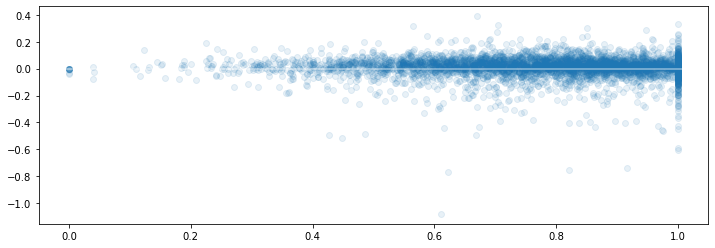

In [75]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(trades.pct, trades.target, alpha=0.1)
ax.axhline(0, c="white", alpha=0.5)

In [65]:
len(trades.loc[trades.pct>0.99])

595

<AxesSubplot:xlabel='timestamp'>

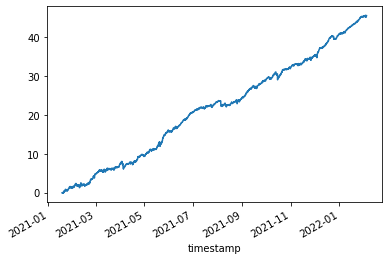

In [74]:
trades.loc[trades.pct<0.99].target.cumsum().plot()

In [35]:
def analyze(trades, func):
    result = []
    for _ in range(len(func)):
        result.append([])
    i = 0
    length = len(trades)
    for i in range(length):
        s = trades.iloc[i].name
        e = s+timedelta(hours=2)
        ss = (s-timedelta(hours=0)).strftime("%d %b %Y %H:%M:%S")
        es = (e+timedelta(hours=0)).strftime("%d %b %Y %H:%M:%S")
        try:
            name = trades.iloc[i].trades.upper()+"USDT"
            klines = client.get_historical_klines(symbol=name, interval = "1m", start_str=ss, end_str=es)
            btc = client.get_historical_klines(symbol="BTCUSDT", interval = "1m", start_str=ss, end_str=es)
            for j in range(len(func)):
                try:
                    result[j].append(func[j](klines, btc))
                except:
                    print(f"Warning: failed for function #{j} for trades.iloc[{i}]")
                    result[j].append(0)
        except:
            print(f"Warning: failed for trades.iloc[{i}]")
            for j in range(len(func)):
                result[j].append(0)
        i += 1
        ui.printProgressBar(i, length)
    return result

In [36]:
def get_max(klines, btc):
    first = float(klines[0][3])
    high = max(list(map(lambda x: float(x[2]), klines)))
    return (high-first)/first

def get_change_in_price(klines, btc):
    series = get_klines_over_btc(klines, btc)
    return series[-1]/series[0]

def get_most_favourable(klines, btc):
    series = get_klines_over_btc(klines, btc)
    low = min(series)
    return (series[0]-low)/series[0]
    
    
def get_closes(klines):
    return list(map(lambda x: float(x[4]), klines))

def get_klines_over_btc(klines, btc):
    return list(map(lambda x, y: x/y, get_closes(klines), get_closes(btc)))

In [37]:
result1 = analyze(trades, [get_max, get_change_in_price, get_most_favourable])

 |██████████████████████████████████████████████████| 100.0% 


In [39]:
df_ = pd.DataFrame({"high":result1[0], "chg":result1[1], "best":result1[2]}, index=trades.index)
print(f"Median: {round((df_.chg.median()-1)*100, 2)}%\nMean: {round((df_.chg.mean()-1)*100, 2)}%")

Median: -1.85%
Mean: -1.07%


In [28]:
result = analyze(trades, [get_max, get_change_in_price, get_most_favourable])

 |██████████████████████████████████████████████████| 100.0% 


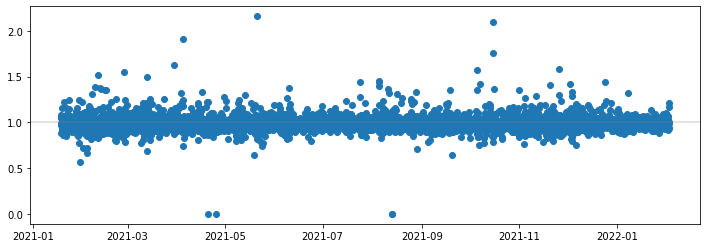

In [40]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(df_.index, df_.chg)
ax.axhline(1, color="gray", alpha=0.3);

In [29]:
df = pd.DataFrame({"high":result[0], "chg":result[1], "best":result[2]}, index=trades.index)

In [30]:
print(f"Median: {round((df.chg.median()-1)*100, 2)}%\nMean: {round((df.chg.mean()-1)*100, 2)}%")

Median: -1.8%
Mean: -1.08%


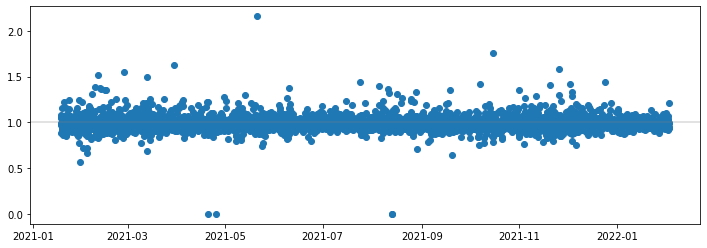

In [31]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(df.index, df.chg)
ax.axhline(1, color="gray", alpha=0.3);

In [13]:
def get_tp_sl(klines, btc, tp, sl):
    series = get_klines_over_btc(klines, btc)
    start = series[0]
    tp_ = [i for i in range(len(series)) if series[i] > start*tp]
    sl_ = [i for i in range(len(series)) if series[i] < start*sl]
    if tp_ == [] and sl_ == []:
        return get_change_in_price(klines, btc)
    elif tp_ == []:
        return sl
    elif sl_ == []:
        return tp
    else: return sl if sl_[0]<tp_[0] else tp
    
def get_150tp(klines, btc):
    return get_tp_sl(klines, btc, 1.5, 0)

def get_096sl(klines, btc):
    return get_tp_sl(klines, btc, 100, 0.96)

def get_150tp_098sl(klines, btc):
    return get_tp_sl(klines, btc, 1.5, 0.98)

def get_150tp_096sl(klines, btc):
    return get_tp_sl(klines, btc, 1.5, 0.96)

def get_150tp_094sl(klines, btc):
    return get_tp_sl(klines, btc, 1.5, 0.94)


In [14]:
funcs = [get_150tp, get_096sl, get_150tp_098sl, get_150tp_096sl, get_150tp_094sl]

In [15]:
result = analyze(trades, funcs)

 |██████████████████████████████████████████████████| 100.0% 


In [16]:
backtest = pd.DataFrame({"tp150":result[0], "sl096":result[1], "tp150sl098":result[2], "tp150sl096":result[3], "tp150sl094":result[4]}, index=trades.index)


In [17]:
backtest.tail()

,tp150,sl096,tp150sl098,tp150sl096,tp150sl094
2022-01-28 06:00:00,0.975155,0.975155,0.980000,0.975155,0.975155
2022-01-29 16:00:00,1.060650,1.060650,0.980000,1.060650,1.060650
2022-01-29 18:00:00,1.030425,1.030425,0.980000,1.030425,1.030425
2022-01-31 08:00:00,0.986089,0.986089,0.986089,0.986089,0.986089
2022-02-02 16:00:00,1.168211,1.168211,1.168211,1.168211,1.168211


In [18]:
backtest = backtest.replace(0, 1)

In [19]:
def get_chg_series(series):
    return pd.Series(list(map(lambda x: -(x-1)-0.004, series)), index=series.index).cumsum()

<AxesSubplot:>

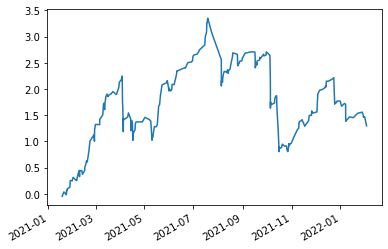

In [20]:
get_chg_series(backtest.tp150).plot()

<AxesSubplot:>

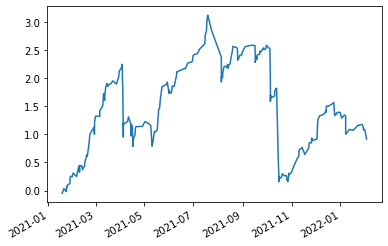

In [21]:
get_chg_series(df.chg).plot()

In [203]:
t = 1
r_ = list(map(lambda x: (1-x)+1-0.005, backtest.tp150.iloc[-12*30:]))
for num in r_:
    t*=num

In [204]:
t

11.49975765131795

In [ ]:
result = 

<AxesSubplot:xlabel='timestamp'>

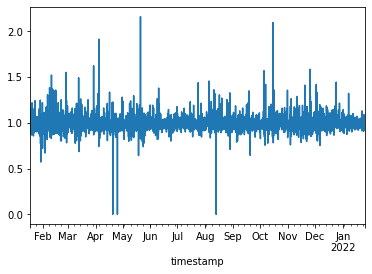

In [105]:
df.chg.plot()

In [96]:
trades.iloc[1100:1110]

,trades
timestamp,
2021-04-19 20:00:00,ctsi
2021-04-19 22:00:00,bat
2021-04-20 00:00:00,nmr
2021-04-20 02:00:00,NaN
2021-04-20 04:00:00,1inch
2021-04-20 06:00:00,axs
2021-04-20 08:00:00,celo
2021-04-20 10:00:00,celo
2021-04-20 12:00:00,mtl


In [89]:
trades.trades.values

array(['omg', 'ksm', 'gto', ..., 'alpaca', 'lrc', 'pyr'], dtype=object)

In [54]:
get_max(klines, btc)

0.050540540540540524

In [52]:
klines[0]

[1643126400000,
 '0.37060000',
 '0.37510000',
 '0.37000000',
 '0.37230000',
 '154908.50000000',
 1643126459999,
 '57691.20557000',
 322,
 '102038.50000000',
 '38022.86013000',
 '0']

In [36]:
s = trades.iloc[4470].name
e = s+timedelta(hours=2)
ss = (s-timedelta(hours=0)).strftime("%d %b %Y %H:%M:%S")
es = (e+timedelta(hours=0)).strftime("%d %b %Y %H:%M:%S")
name = trades.iloc[4470].trades.upper()+"USDT"
klines = client.get_historical_klines(symbol=name, interval = "1m", start_str=ss, end_str=es)
btc = client.get_historical_klines(symbol="BTCUSDT", interval = "1m", start_str=ss, end_str=es)

In [43]:
ratio = list(map(lambda x, y: float(x[4])/float(y[4]), klines, btc))

In [47]:
ratio

[1.018613847949927e-05,
 1.0087239286346988e-05,
 1.0035773647886071e-05,
 1.0054118024204703e-05,
 1.0155451492175068e-05,
 1.0567557978506273e-05,
 1.0418685924125974e-05,
 1.0321730837024872e-05,
 1.035518248582349e-05,
 1.0422645511545188e-05,
 1.0433717283593014e-05,
 1.0338784791783966e-05,
 1.034985458577227e-05,
 1.03513640095705e-05,
 1.0298731526359999e-05,
 1.0269086638016198e-05,
 1.0266199165898564e-05,
 1.0311500971262817e-05,
 1.0299276876628794e-05,
 1.0232586417856487e-05,
 1.0169611096489204e-05,
 1.0066623583397989e-05,
 1.002417755562196e-05,
 1.0046622948667561e-05,
 1.0057564896274574e-05,
 1.0038040750532405e-05,
 1.0077238928810942e-05,
 1.0123687058807513e-05,
 1.0098540986508361e-05,
 1.0058258499146856e-05,
 1.0013136125650181e-05,
 9.999556361544112e-06,
 9.983732931881415e-06,
 1.0005875258639105e-05,
 9.97872347948215e-06,
 9.9750759150622e-06,
 1.0045088564197506e-05,
 9.946519753047416e-06,
 9.94550408719346e-06,
 9.945501377247581e-06,
 9.91116728105188

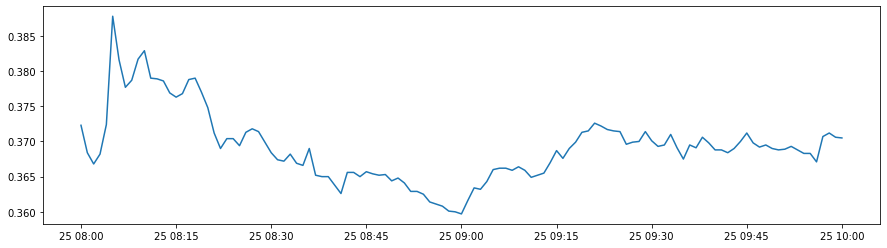

In [38]:
d = pd.DataFrame(list(map(lambda x: float(x[4]), klines)), 
                  index=list(map(lambda x: datetime.fromtimestamp(x[0] / 1e3), klines)), 
                  columns=['price'])
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(d.index, d.price)
# ax.axvline(s-timedelta(hours=8))
# ax.axvline(e-timedelta(hours=8))

In [20]:
for trade in trades:
    

'cos'

In [5]:
all_assets = client.get_all_isolated_margin_symbols()
all_assets = list(filter(lambda x: x['quote']=="USDT", all_assets))
all_assets = list(filter(lambda x: x['isMarginTrade']==True, all_assets))
all_assets = list(map(lambda x: x['base'], all_assets))

In [6]:
if "BTC" in all_assets: all_assets.remove("BTC")
df = bdl.get_timeseries_data("BTCUSDT").close.rename("btc").to_frame()

iteration = 0
total = len(assets)

for asset in assets:
    if progress: ui.printProgressBar(iteration, total)
    iteration += 1
    time.sleep(sleep)

    try:
        new = (bdl.get_timeseries_data(asset+quote)['close']/df.btc).rename(asset.lower())
        df = pd.concat([df, new], axis=1)
    except:
        print(f"Warning: No symbol exists: {asset+quote}")

ui.printProgressBar(iteration, total)

df.to_csv(PATH+BACKTESTING)

return df

['1INCH',
 'AAVE',
 'ADA',
 'AGLD',
 'AION',
 'AKRO',
 'ALCX',
 'ALGO',
 'ALICE',
 'ALPACA',
 'ALPHA',
 'AMP',
 'ANKR',
 'ANT',
 'ANY',
 'ARDR',
 'ARPA',
 'AR',
 'ATA',
 'ATOM',
 'AUDIO',
 'AUD',
 'AUTO',
 'AVAX',
 'AXS',
 'BADGER',
 'BAKE',
 'BAL',
 'BAND',
 'BAT',
 'BCH',
 'BEAM',
 'BEL',
 'BETA',
 'BICO',
 'BLZ',
 'BNB',
 'BNT',
 'BNX',
 'BOND',
 'BTCST',
 'BTC',
 'BTG',
 'BTS',
 'BTT',
 'BURGER',
 'BUSD',
 'BZRX',
 'C98',
 'CAKE',
 'CELO',
 'CELR',
 'CFX',
 'CHESS',
 'CHR',
 'CHZ',
 'CKB',
 'CLV',
 'COCOS',
 'COMP',
 'COS',
 'COTI',
 'CRV',
 'CTK',
 'CTSI',
 'CTXC',
 'CVC',
 'CVP',
 'CVX',
 'DAR',
 'DASH',
 'DATA',
 'DCR',
 'DEGO',
 'DENT',
 'DEXE',
 'DGB',
 'DIA',
 'DNT',
 'DOCK',
 'DODO',
 'DOGE',
 'DOT',
 'DREP',
 'DUSK',
 'DYDX',
 'EGLD',
 'ELF',
 'ENJ',
 'ENS',
 'EOS',
 'EPS',
 'ERN',
 'ETC',
 'ETH',
 'EUR',
 'FARM',
 'FET',
 'FIL',
 'FIO',
 'FIRO',
 'FIS',
 'FLM',
 'FLOW',
 'FLUX',
 'FORTH',
 'FOR',
 'FTM',
 'FTT',
 'FUN',
 'GALA',
 'GBP',
 'GNO',
 'GRT',
 'GTC',
 'GTO',
 'GX